# Useful functions throughout the code

In [1]:
def plot_sed(x, y, yerr):
    plt.clf()
    plt.errorbar(wavelength, flux, yerr=flux_err, c='red', ecolor='gray', capthick=2)
    plt.show()

In [2]:
def fwhm_gama(wave):
    fwhm = wave/1300.
    return(fwhm)

# Libraries

In [3]:
# usual libraries ----------------------------------------------------------------------------------------------------
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import astropy.io.fits   as pf
import astropy.constants as ct
import scipy.interpolate as sci
import ipywidgets        as widgets
import datetime          as dt
import os
import time

In [4]:
# ppxf separately ----------------------------------------------------------------------------------------------------
import ppxf.miles_util   as lib  # MILES library embedded in ppxf
import ppxf.ppxf_util    as util
import ppxf              as ppxf_module
from ppxf.ppxf           import ppxf
from ppxf.ppxf_util      import log_rebin

# Dataset

In [5]:
dataset_path = './../../Catalogue/Match08_smallemlines_inputcattype.csv'
my_data      = pd.read_csv(dataset_path)

In [6]:
whan_class = my_data['WHAN_CLASS'].values.astype(str)
uv_class   = my_data['UV_CLASS_YI2011'].values.astype(str)
cataid     = my_data['CATAID'].values.astype(str)
specid     = my_data['SPECID'].values.astype(str)
s2n        = my_data['S2N'].values.astype(float)
chi2_gama  = my_data['CHI2'].values.astype(float)
redshift   = my_data['Z'].values.astype(float)

In [7]:
idx_uvup_rp = np.where((uv_class=='UV_UPTURN')*(whan_class=='Retired/Passive'))

## Plot the distributions of S/N

### Plot settings (yes, I'm lazy)

In [ ]:
bins = 20
palette = ['#a6611a','#dfc27d','#80cdc1','#018571']
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.

### Histogram - S/N and $\chi^2$

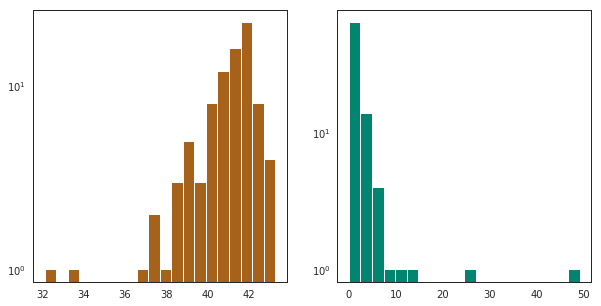

In [ ]:
plt.subplots(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(s2n[idx_uvup_rp], bins=bins, color=palette[0])
plt.yscale('log')
plt.subplot(1,2,2)
plt.hist(chi2_gama[idx_uvup_rp], bins=bins, color=palette[3])
plt.yscale('log')
plt.show()

### Selecting top 10 objects with the best S2N

In [ ]:
# best_s2n_10 = np.argsort(s2n[idx_uvup_rp])[-10:-1]

In [ ]:
# s2n_top10 = s2n[idx_uvup_rp][best_s2n_10]    # top 10 objects given the S/N

In [ ]:
# chi2_top   = chi2_gama[idx_uvup_rp][best_s2n_10]
# specid_top = specid[idx_uvup_rp][best_s2n_10]

# pPXF

## Configuring inputs

In [ ]:
ppxf_dir     = os.path.dirname(os.path.realpath(ppxf_module.__file__))
miles_lib    = ppxf_dir+'/miles_models/Mun1.30*.fits'
seds_path    = './../../../../GAMADR3_SPECTRA/DATABASE/'
results_path = './Results/'

light_speed  = float(str(ct.c.to('km/s')).split(' ')[0])            # selecting the numerical values (must be in km/s)

In [ ]:
# seds_list = []
# for i in specid_top: seds_list.append(i+'.fit')
seds_list_all = []
for i in specid[idx_uvup_rp]: seds_list_all.append(i+'.fit')

In [ ]:
bar = widgets.IntProgress(value=0, min=0, max=len(seds_list_all)+1, step=0.25, description='Running pPXF:',
                          orientation='horizontal')
display(bar)

IntProgress(value=0, description='Running pPXF:', max=88)

### pPXF plot settings

In [ ]:
palette      = ['#ef8a62','#f7f7f7','#67a9cf']
transparency = 0.8
lw           = 2.

## pPXF settings

In [ ]:
# Fit (V, sig, h3, h4) moments=4 for the stars; (V, sig) moments=2 for the two gas kinematic components
moments        = [4, 2, 2]
degree         = -1         # Additive Legendre polynomial degrees
mdegree        = 250        # Multiplicative Legendre polynomial degrees
regul_err      = 0.01       # Desired regularization error -- TODO: MUST CHECK WHY 0.013
tied_balmer    = True
limit_doublets = False
stellar_comp_w = [0]        # weight of the stellar component
balmer_comp_w  = [1]        # weight of the balmer emission lines
forbid_comp_w  = [2]        # weight of the forbidden lines
wl_min_miles   = 3540       # MILES RANGE MIN
wl_max_miles   = 7409       # MILES RANGE MAX
wl_min         = 4350       # removing the bluest part of the spectra in order to mitigate noise effects
wl_max         = 7409

In [ ]:
mean_age   = ['<logAge>']
mean_metal = ['<[M/H]>']
mass2light = ['MASS2LIGHT_R']
ids        = ['CATAID']
redshifts  = ['Z']
s2n_runz   = ['S2N_runz']
ppxf_chi2  = ['CHI2_PPXF']

/home/mlldantas/anaconda3/envs/py3k6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     48458      1000     0.270     0.300
 comp. 1:     47734         1
 comp. 2:     47499       180
chi2/DOF: 0.007571
method = capfit ; Jac calls: 10 ; Func calls: 2608 ; Status: 2
Gas Reddening E(B-V): 2.428
Nonzero Templates:  75  /  155
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown     0.1044       1.6   47734     1
Comp: 2       Unknown          0       8.6   47499   180
Comp: 2       Unknown          0       8.5   47499   180
Comp: 2       Unknown          0       4.4   47499   180
Comp: 2       Unknown          0       3.1   47499   180
---------------------------------------------------------
Weighted <logAge> [yr]: 9.88
Weighted <[M/H]>: -0.196
Weighted <logAge> [yr]: 

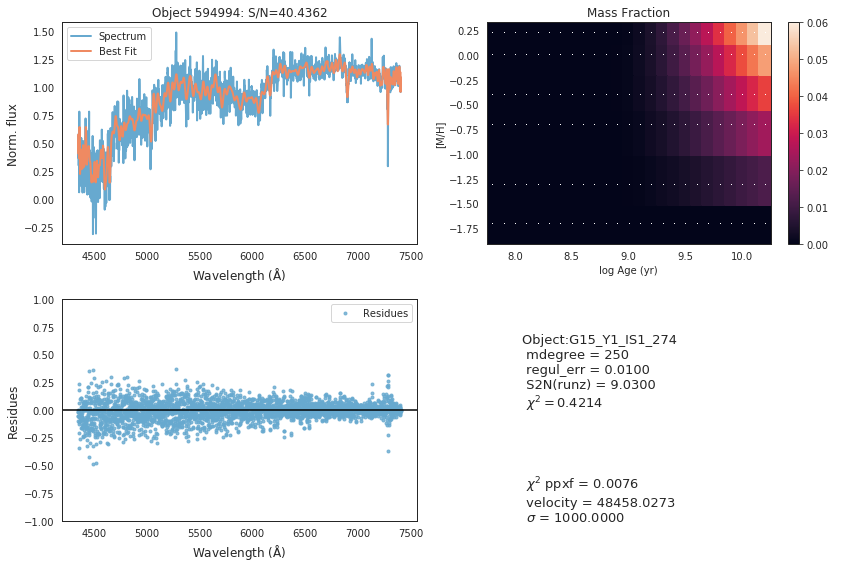

We have run 1 galaxies so far


/home/mlldantas/anaconda3/envs/py3k6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


Emission lines included in gas templates:
['Balmer' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     44064      1000     0.045     0.175
 comp. 1:     43949       237
 comp. 2:     44082       174
chi2/DOF: 0.004135
method = capfit ; Jac calls: 12 ; Func calls: 3125 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  94  /  153
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown          0         5   43949   237
Comp: 2       Unknown          0       4.3   44082   174
Comp: 2       Unknown      1.345       3.3   44082   174
---------------------------------------------------------
Weighted <logAge> [yr]: 9.83
Weighted <[M/H]>: -0.223
Weighted <logAge> [yr]: 9.83
Weighted <[M/H]>: -0.223
M/L_r: 2.615
Current $\chi^2$: 0.0041
Elapsed time in PPXF: 22.25 [min]
Weighted <logAge> [yr]: 9.83
Weighte

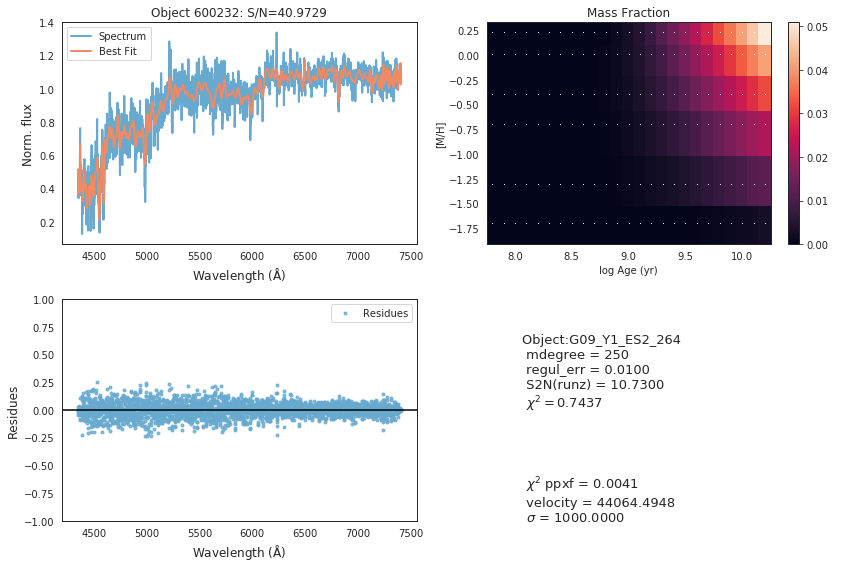

We have run 2 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     37909      1000     0.250     0.300
 comp. 1:     37686      1000
 comp. 2:     38307        50
chi2/DOF: 0.00416
method = capfit ; Jac calls: 17 ; Func calls: 4426 ; Status: 2
Gas Reddening E(B-V): 8.037
Nonzero Templates:  107  /  153
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      72.06       5.8   37686  1000
Comp: 2       Unknown          0       3.1   38307    50
Comp: 2       Unknown     0.4112       2.1   38307    50
---------------------------------------------------------
Weighted <logAge> [yr]: 9.86
Weighted <[M/H]>: -0.425
Weighted <logAge> [yr]: 9.86
Weighted <[M/H]>: -0.425
M/L_r: 2.405
Current $\chi^2$: 0.0042
Elapsed time in PPXF: 34.78 [min]
Weight

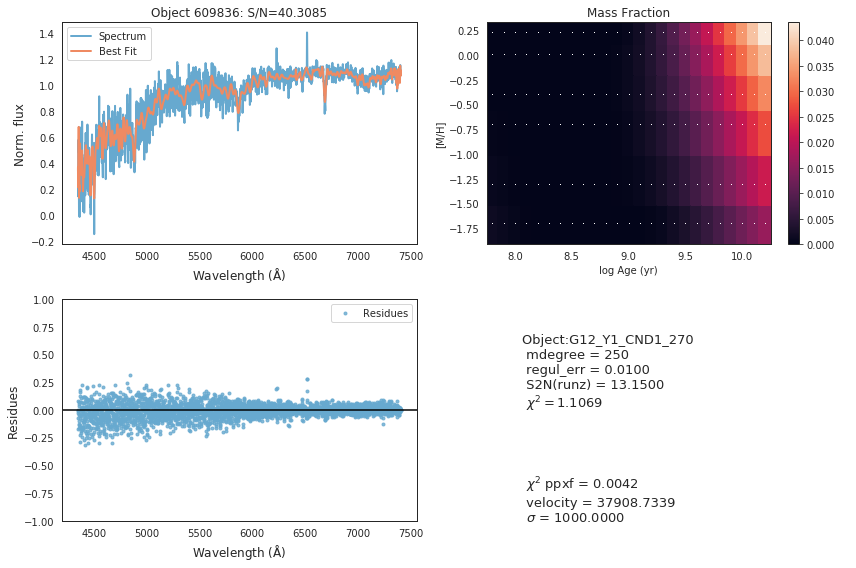

We have run 3 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     39231      1000    -0.026     0.155
 comp. 1:     39218       250
 comp. 2:     39491         1
chi2/DOF: 0.01103
method = capfit ; Jac calls: 11 ; Func calls: 2864 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  141  /  153
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown        3.1       4.9   39218   250
Comp: 2       Unknown     0.5349       2.9   39491     1
Comp: 2       Unknown          0         2   39491     1
---------------------------------------------------------
Weighted <logAge> [yr]: 9.75
Weighted <[M/H]>: -0.618
Weighted <logAge> [yr]: 9.75
Weighted <[M/H]>: -0.618
M/L_r: 1.434
Current $\chi^2$: 0.0110
Elapsed time in PPXF: 20.65 [min]
Weight

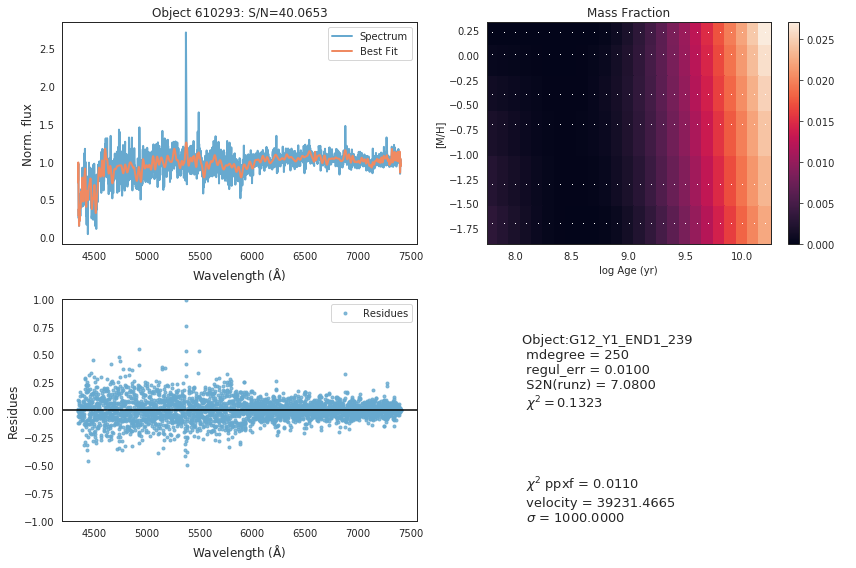

We have run 4 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     66773      1000     0.022    -0.015
 comp. 1:     66590       183
 comp. 2:     67426        46
chi2/DOF: 0.005249
method = capfit ; Jac calls: 13 ; Func calls: 3383 ; Status: 2
Gas Reddening E(B-V): 4.759
Nonzero Templates:  116  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown     0.3889       2.2   66590   183
Comp: 2       Unknown     0.4046       3.7   67426    46
Comp: 2       Unknown     0.2228       3.7   67426    46
Comp: 2       Unknown     0.9682         3   67426    46
---------------------------------------------------------
Weighted <logAge> [yr]: 9.78
Weighted <[M/H]>: -0.39
Weighted <logAge> [yr]: 9.78
Weighted <[M/H]>: -0.39
M/L_r: 2.10

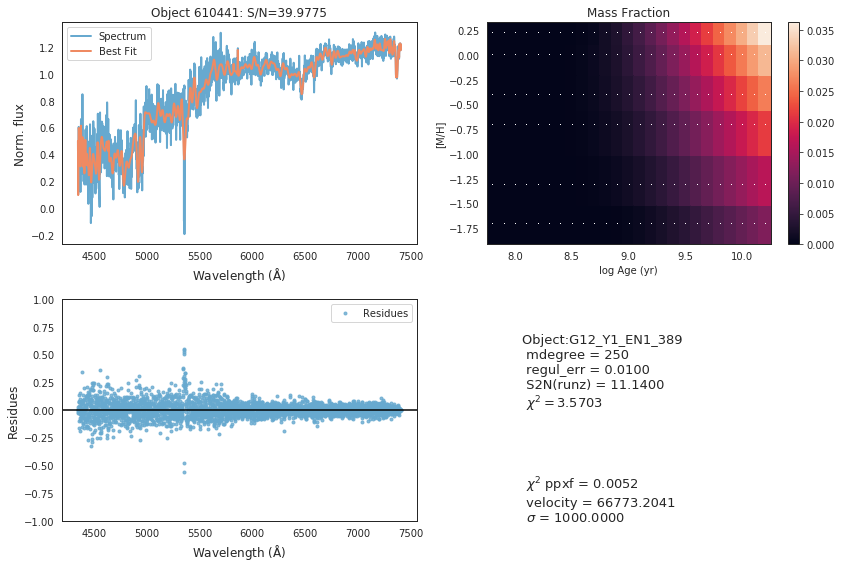

We have run 5 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     34922       810     0.024     0.147
 comp. 1:     35367       530
 comp. 2:     35000       596
chi2/DOF: 0.0174
method = capfit ; Jac calls: 9 ; Func calls: 2343 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  141  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      14.92        11   35367   530
Comp: 2       Unknown          0       6.9   35000   596
Comp: 2       Unknown      6.417       4.9   35000   596
Comp: 2       Unknown          0       6.8   35000   596
---------------------------------------------------------
Weighted <logAge> [yr]: 9.76
Weighted <[M/H]>: -0.589
Weighted <logAge> [yr]: 9.76
Weighted <[M/H]>: -0.589
M/L_r: 1.

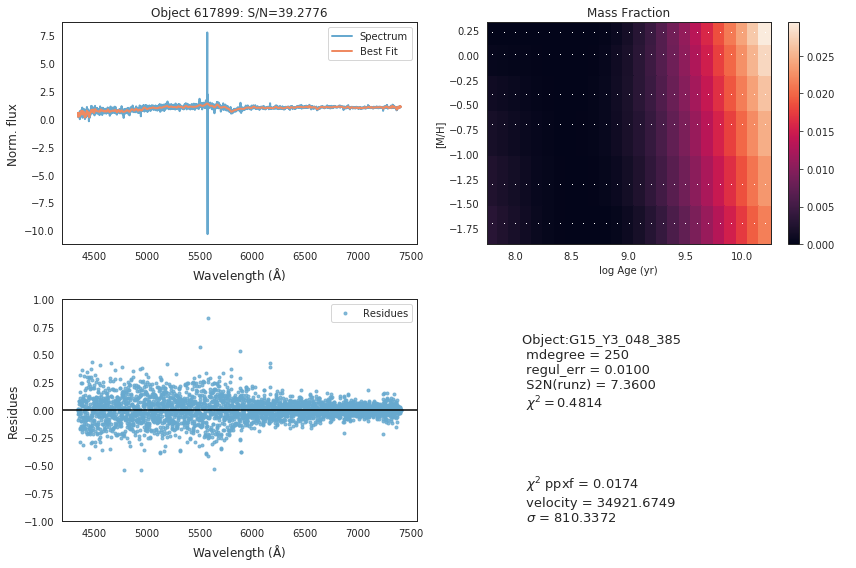

We have run 6 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     58135      1000     0.131     0.075
 comp. 1:     58886       852
 comp. 2:     58590       416
chi2/DOF: 0.0153
method = capfit ; Jac calls: 9 ; Func calls: 2342 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  104  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      57.21        10   58886   852
Comp: 2       Unknown      5.247        21   58590   416
Comp: 2       Unknown          0        21   58590   416
Comp: 2       Unknown       5.42       6.8   58590   416
---------------------------------------------------------
Weighted <logAge> [yr]: 9.8
Weighted <[M/H]>: -0.283
Weighted <logAge> [yr]: 9.8
Weighted <[M/H]>: -0.283
M/L_r: 2.385
C

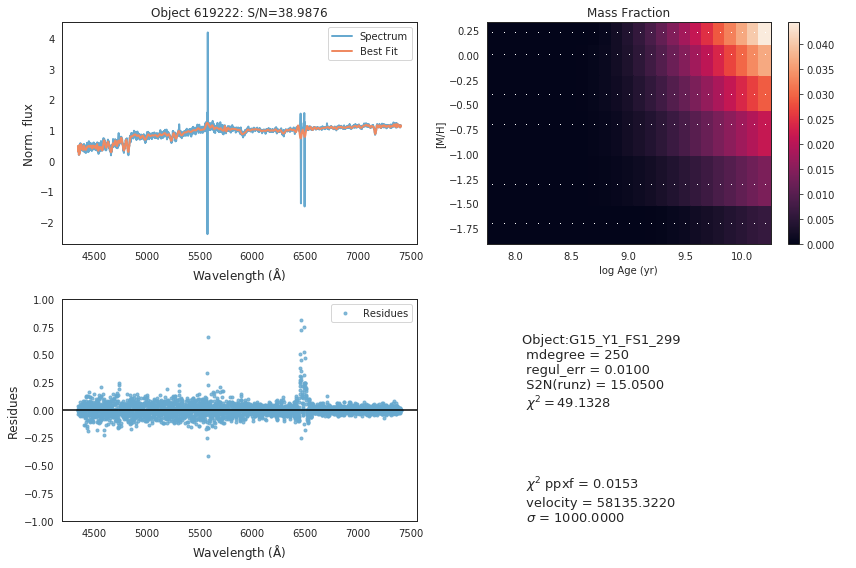

We have run 7 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     49587      1000     0.044     0.132
 comp. 1:     49495       456
 comp. 2:     49573       196
chi2/DOF: 0.01493
method = capfit ; Jac calls: 8 ; Func calls: 2084 ; Status: 2
Gas Reddening E(B-V): 2.964
Nonzero Templates:  126  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      2.869       3.1   49495   456
Comp: 2       Unknown          0       7.9   49573   196
Comp: 2       Unknown          0       8.1   49573   196
Comp: 2       Unknown          0         5   49573   196
---------------------------------------------------------
Weighted <logAge> [yr]: 9.81
Weighted <[M/H]>: -0.583
Weighted <logAge> [yr]: 9.81
Weighted <[M/H]>: -0.583
M/L_r: 2.08

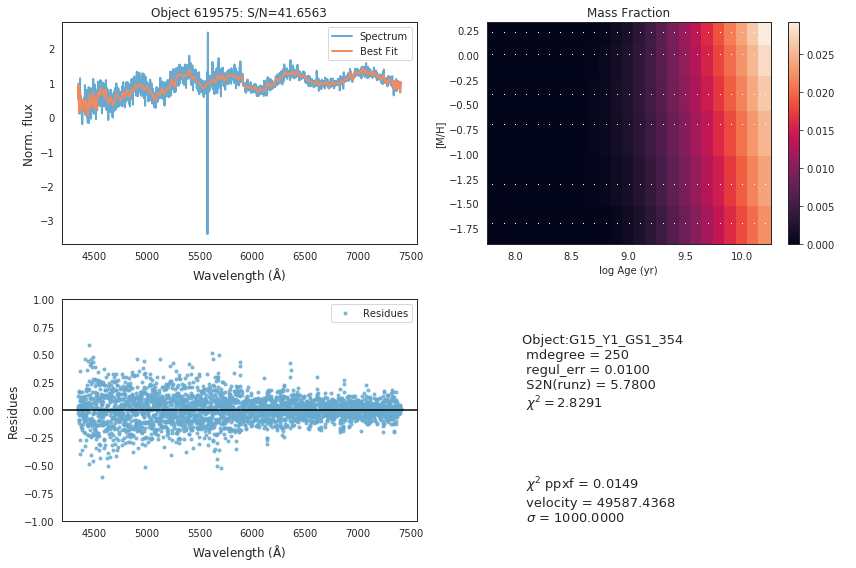

We have run 8 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     53172      1000    -0.001     0.142
 comp. 1:     53356       330
 comp. 2:     53223       411
chi2/DOF: 0.02644
method = capfit ; Jac calls: 10 ; Func calls: 2604 ; Status: 2
Gas Reddening E(B-V): 4.047
Nonzero Templates:  137  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      2.162       2.1   53356   330
Comp: 2       Unknown          0        60   53223   411
Comp: 2       Unknown          0        60   53223   411
Comp: 2       Unknown      11.39       8.4   53223   411
---------------------------------------------------------
Weighted <logAge> [yr]: 9.79
Weighted <[M/H]>: -0.622
Weighted <logAge> [yr]: 9.79
Weighted <[M/H]>: -0.622
M/L_r: 1.6

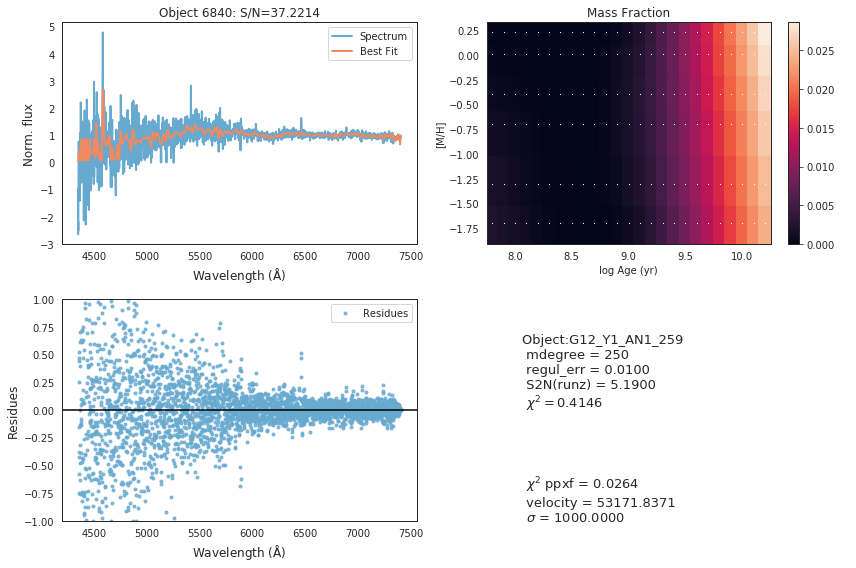

We have run 9 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     45322      1000     0.163     0.260
 comp. 1:     45421         1
 comp. 2:     44026       938
chi2/DOF: 0.003268
method = capfit ; Jac calls: 18 ; Func calls: 4687 ; Status: 2
Gas Reddening E(B-V): 3.146
Nonzero Templates:  86  /  153
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown          0       1.7   45421     1
Comp: 2       Unknown          0       8.7   44026   938
Comp: 2       Unknown      44.95       6.9   44026   938
---------------------------------------------------------
Weighted <logAge> [yr]: 9.84
Weighted <[M/H]>: -0.199
Weighted <logAge> [yr]: 9.84
Weighted <[M/H]>: -0.199
M/L_r: 2.753
Current $\chi^2$: 0.0033
Elapsed time in PPXF: 34.03 [min]
Weight

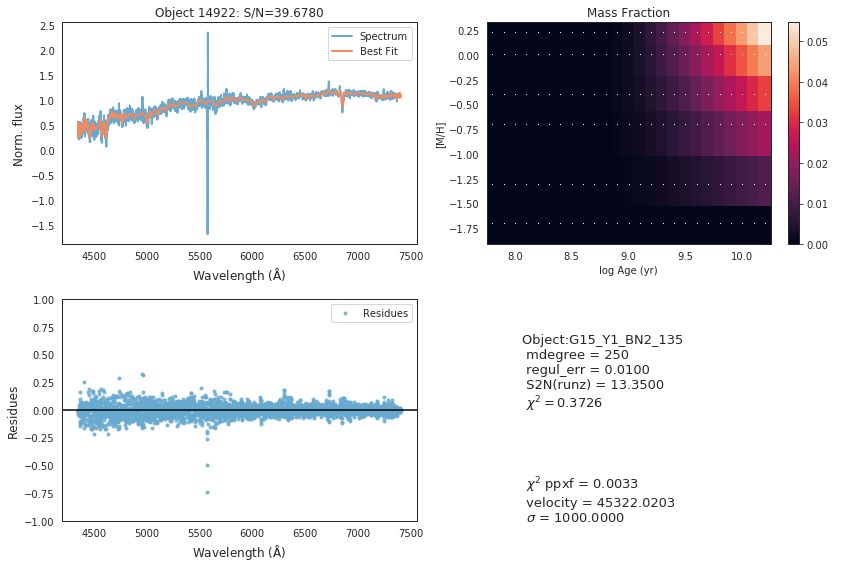

We have run 10 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     41910       827     0.027     0.169
 comp. 1:     41671       819
 comp. 2:     41862        59
chi2/DOF: 0.003859
method = capfit ; Jac calls: 18 ; Func calls: 4683 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  145  /  153
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      46.81       7.3   41671   819
Comp: 2       Unknown     0.8534       3.5   41862    59
Comp: 2       Unknown          0         2   41862    59
---------------------------------------------------------
Weighted <logAge> [yr]: 9.73
Weighted <[M/H]>: -0.486
Weighted <logAge> [yr]: 9.73
Weighted <[M/H]>: -0.486
M/L_r: 1.679
Current $\chi^2$: 0.0039
Elapsed time in PPXF: 36.69 [min]
Weig

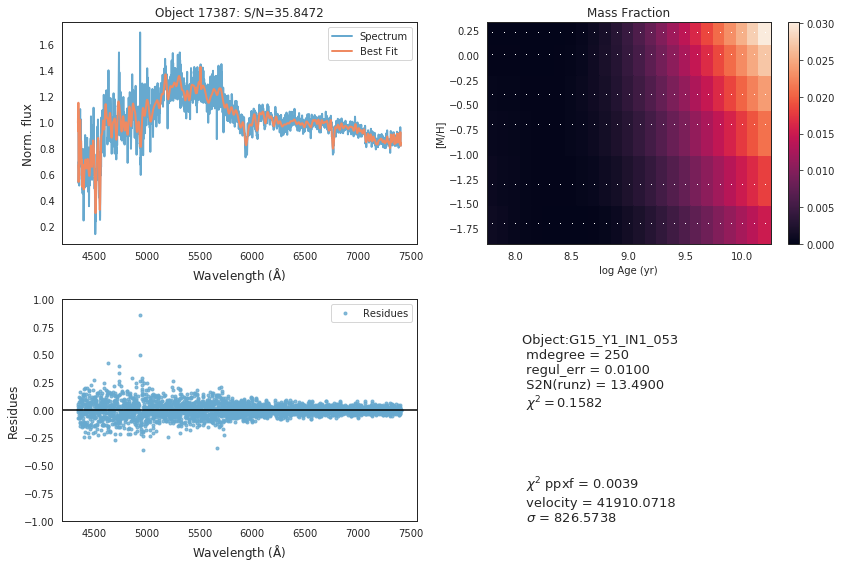

We have run 11 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     49514      1000     0.137     0.300
 comp. 1:     49593        87
 comp. 2:     49701         1
chi2/DOF: 0.009671
method = capfit ; Jac calls: 8 ; Func calls: 2085 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  75  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      0.519         3   49593    87
Comp: 2       Unknown          0         4   49701     1
Comp: 2       Unknown          0       4.3   49701     1
Comp: 2       Unknown          0       3.3   49701     1
---------------------------------------------------------
Weighted <logAge> [yr]: 9.88
Weighted <[M/H]>: -0.196
Weighted <logAge> [yr]: 9.88
Weighted <[M/H]>: -0.196
M/L_r: 3.0

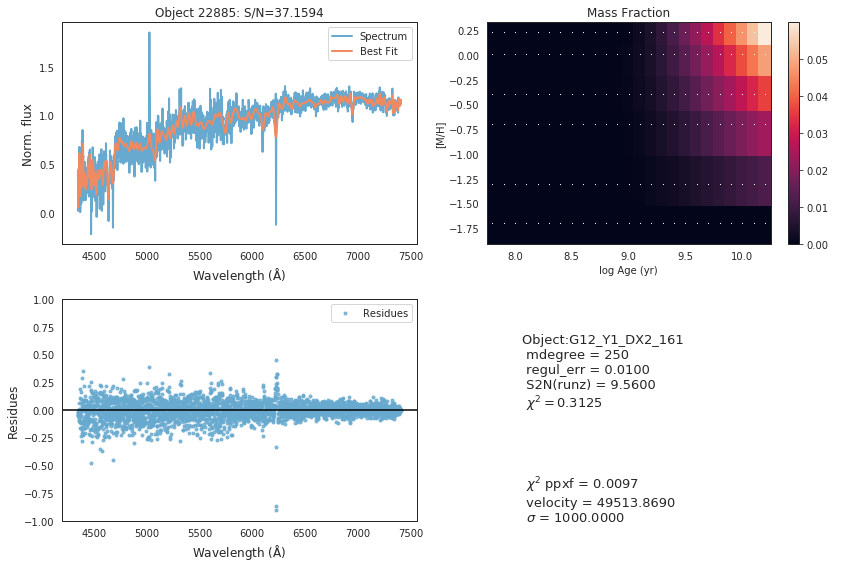

We have run 12 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     29810      1000    -0.300     0.300
 comp. 1:     31057      1000
 comp. 2:     31653       750
chi2/DOF: 0.003733
method = capfit ; Jac calls: 19 ; Func calls: 4947 ; Status: 2
Gas Reddening E(B-V): 6.591
Nonzero Templates:  100  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      95.22        11   31057  1000
Comp: 2       Unknown          0       7.7   31653   750
Comp: 2       Unknown          0       7.1   31653   750
Comp: 2       Unknown      22.22       6.3   31653   750
---------------------------------------------------------
Weighted <logAge> [yr]: 9.87
Weighted <[M/H]>: -0.373
Weighted <logAge> [yr]: 9.87
Weighted <[M/H]>: -0.373
M/L_r

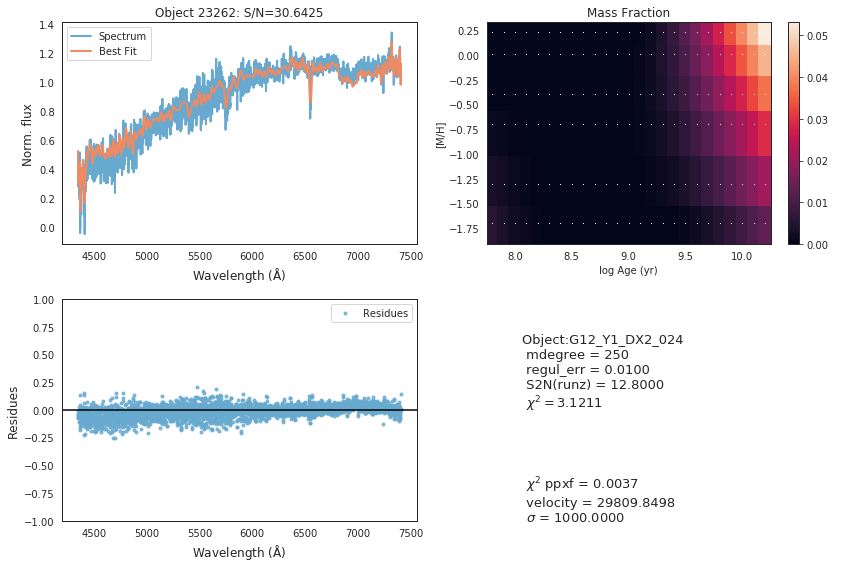

We have run 13 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     46231      1000     0.300     0.300
 comp. 1:     43628      1000
 comp. 2:     44310       913
chi2/DOF: 0.02534
method = capfit ; Jac calls: 19 ; Func calls: 4950 ; Status: 2
Gas Reddening E(B-V): 10.000
Nonzero Templates:  80  /  153
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      42.94       4.5   43628  1000
Comp: 2       Unknown          0       8.5   44310   913
Comp: 2       Unknown      47.96       5.9   44310   913
---------------------------------------------------------
Weighted <logAge> [yr]: 9.9
Weighted <[M/H]>: -0.237
Weighted <logAge> [yr]: 9.9
Weighted <[M/H]>: -0.237
M/L_r: 3.147
Current $\chi^2$: 0.0253
Elapsed time in PPXF: 40.61 [min]
Weighte

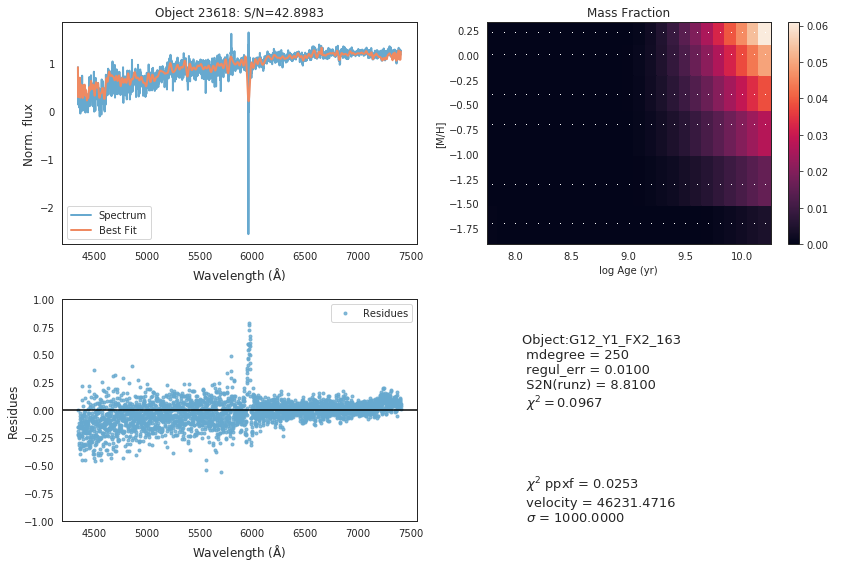

We have run 14 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     50512       921     0.083     0.230
 comp. 1:     50344       669
 comp. 2:     50722         1
chi2/DOF: 0.006924
method = capfit ; Jac calls: 14 ; Func calls: 3643 ; Status: 2
Gas Reddening E(B-V): 4.935
Nonzero Templates:  92  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      16.09       3.8   50344   669
Comp: 2       Unknown      2.038       3.5   50722     1
Comp: 2       Unknown     0.6754       3.6   50722     1
Comp: 2       Unknown     0.8786       3.3   50722     1
---------------------------------------------------------
Weighted <logAge> [yr]: 9.84
Weighted <[M/H]>: -0.203
Weighted <logAge> [yr]: 9.84
Weighted <[M/H]>: -0.203
M/L_r: 2.

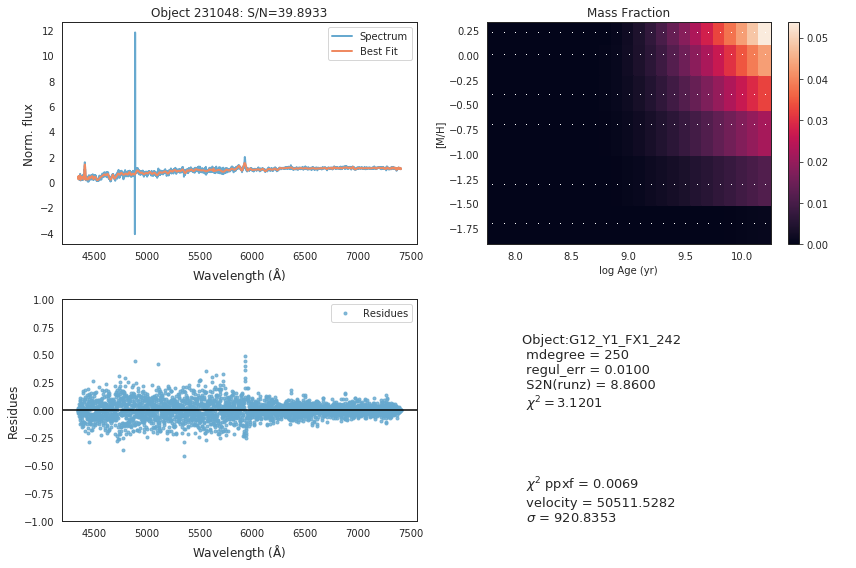

We have run 15 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     56193      1000     0.047     0.097
 comp. 1:     55797       721
 comp. 2:     56436       167
chi2/DOF: 0.005596
method = capfit ; Jac calls: 13 ; Func calls: 3384 ; Status: 2
Gas Reddening E(B-V): 5.065
Nonzero Templates:  102  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      17.02       4.1   55797   721
Comp: 2       Unknown          0       7.3   56436   167
Comp: 2       Unknown          0       7.1   56436   167
Comp: 2       Unknown          0       5.4   56436   167
---------------------------------------------------------
Weighted <logAge> [yr]: 9.81
Weighted <[M/H]>: -0.326
Weighted <logAge> [yr]: 9.81
Weighted <[M/H]>: -0.326
M/L_r: 2

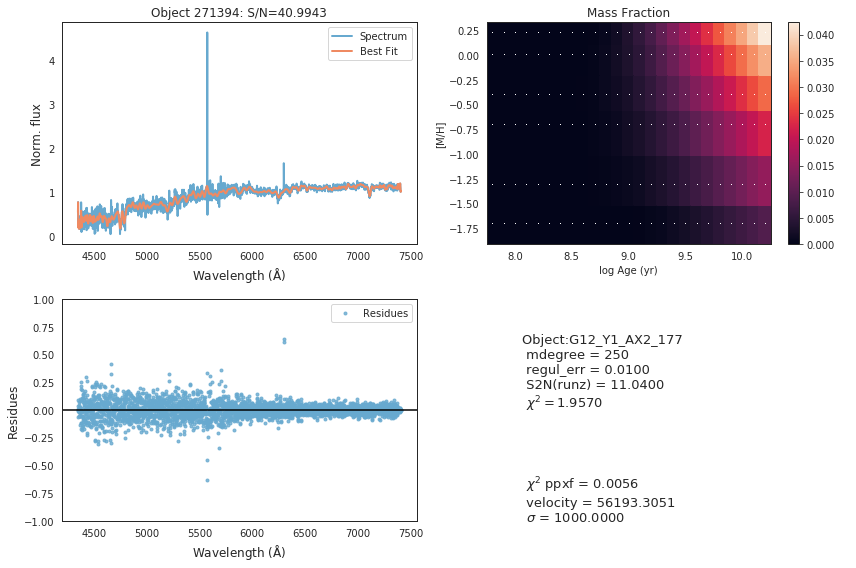

We have run 16 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     45923      1000     0.300     0.300
 comp. 1:     43596      1000
 comp. 2:     43873      1000
chi2/DOF: 0.01893
method = capfit ; Jac calls: 11 ; Func calls: 2864 ; Status: 2
Gas Reddening E(B-V): 10.000
Nonzero Templates:  75  /  153
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown       41.4       5.7   43596  1000
Comp: 2       Unknown          0        11   43873  1000
Comp: 2       Unknown      56.02       7.7   43873  1000
---------------------------------------------------------
Weighted <logAge> [yr]: 9.91
Weighted <[M/H]>: -0.21
Weighted <logAge> [yr]: 9.91
Weighted <[M/H]>: -0.21
M/L_r: 3.251
Current $\chi^2$: 0.0189
Elapsed time in PPXF: 20.86 [min]
Weighte

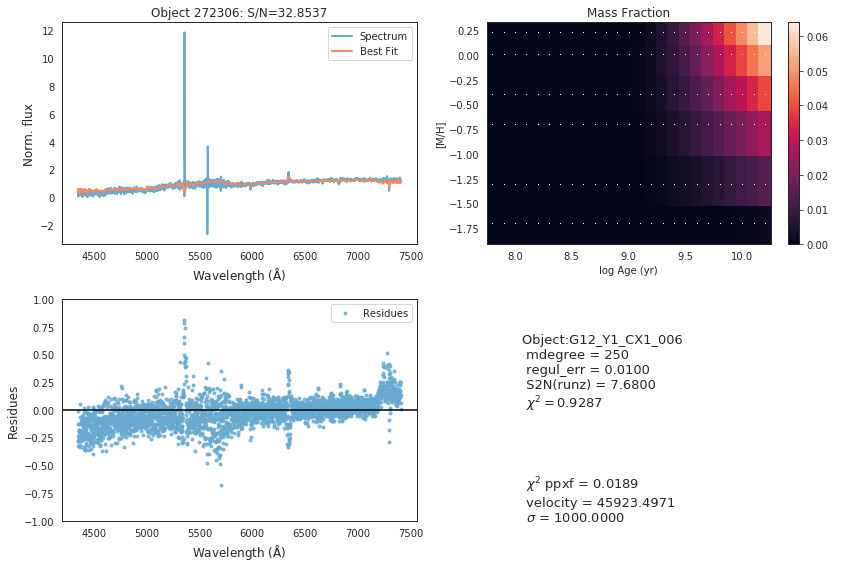

We have run 17 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     51408       752    -0.300    -0.066
 comp. 1:     50609      1000
 comp. 2:     51114      1000
chi2/DOF: 0.003523
method = capfit ; Jac calls: 24 ; Func calls: 6249 ; Status: 2
Gas Reddening E(B-V): 10.000
Nonzero Templates:  76  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      43.05       5.2   50609  1000
Comp: 2       Unknown      73.53   1.1e+02   51114  1000
Comp: 2       Unknown          0        98   51114  1000
Comp: 2       Unknown          0       9.6   51114  1000
---------------------------------------------------------
Weighted <logAge> [yr]: 9.88
Weighted <[M/H]>: -0.196
Weighted <logAge> [yr]: 9.88
Weighted <[M/H]>: -0.196
M/L_r: 3

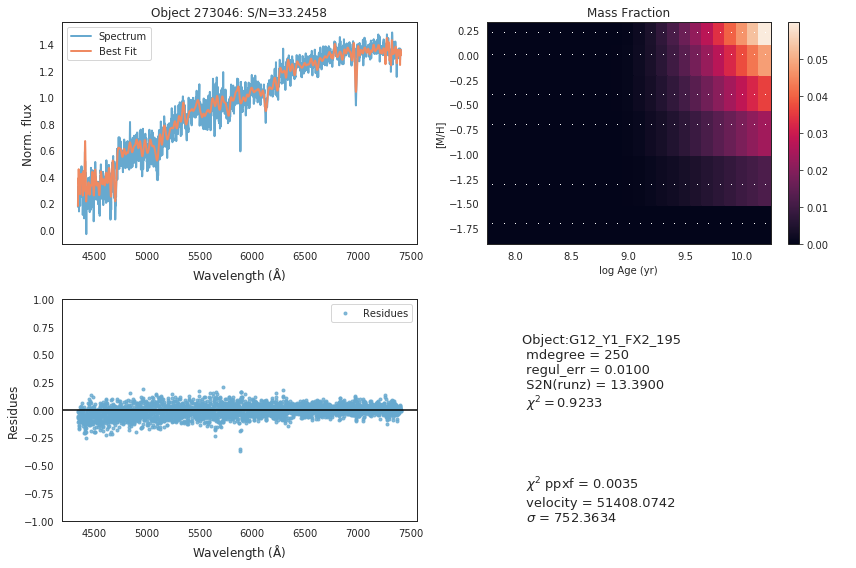

We have run 18 galaxies so far
Emission lines included in gas templates:
['Balmer' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d'
 '[NII]6583_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     22903       982    -0.030     0.201
 comp. 1:     22377       434
 comp. 2:     22316       637
chi2/DOF: 0.003139
method = capfit ; Jac calls: 13 ; Func calls: 3387 ; Status: 2
Gas Reddening E(B-V): 0.642
Nonzero Templates:  144  /  156
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      17.62       8.4   22377   434
Comp: 2       Unknown          0       6.2   22316   637
Comp: 2       Unknown      1.982       6.2   22316   637
Comp: 2       Unknown          0       7.2   22316   637
Comp: 2       Unknown      3.548       5.4   22316   637
Comp: 2       Unknown      20.16       6.1   22316   637
--------------------------------

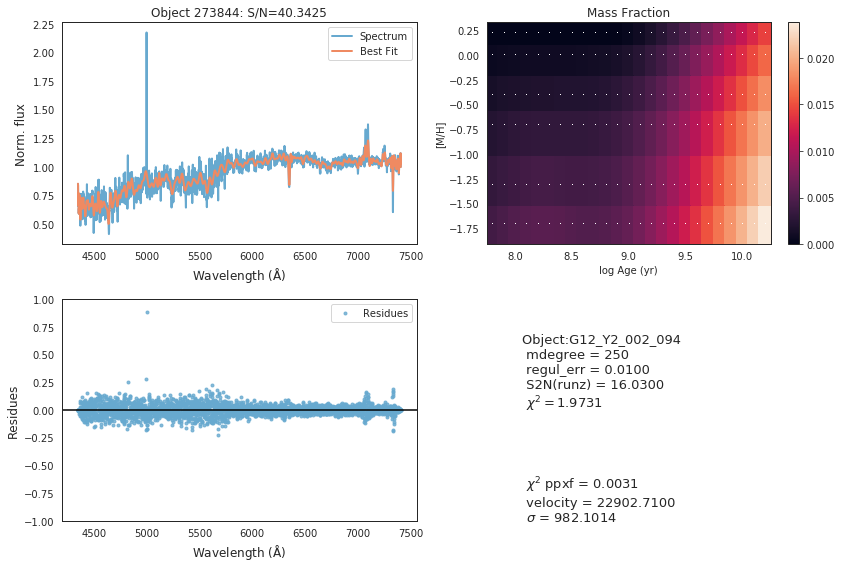

We have run 19 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     49179      1000     0.300     0.300
 comp. 1:     47996      1000
 comp. 2:     48431        71
chi2/DOF: 0.003471
method = capfit ; Jac calls: 13 ; Func calls: 3388 ; Status: 2
Gas Reddening E(B-V): 8.656
Nonzero Templates:  77  /  155
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      37.78       5.3   47996  1000
Comp: 2       Unknown    0.08359       4.4   48431    71
Comp: 2       Unknown          0       1.1   48431    71
Comp: 2       Unknown          0       3.9   48431    71
Comp: 2       Unknown     0.4208       2.8   48431    71
---------------------------------------------------------
Weighted <logAge> [yr]: 9.88
Weighted <[M/H]>: 

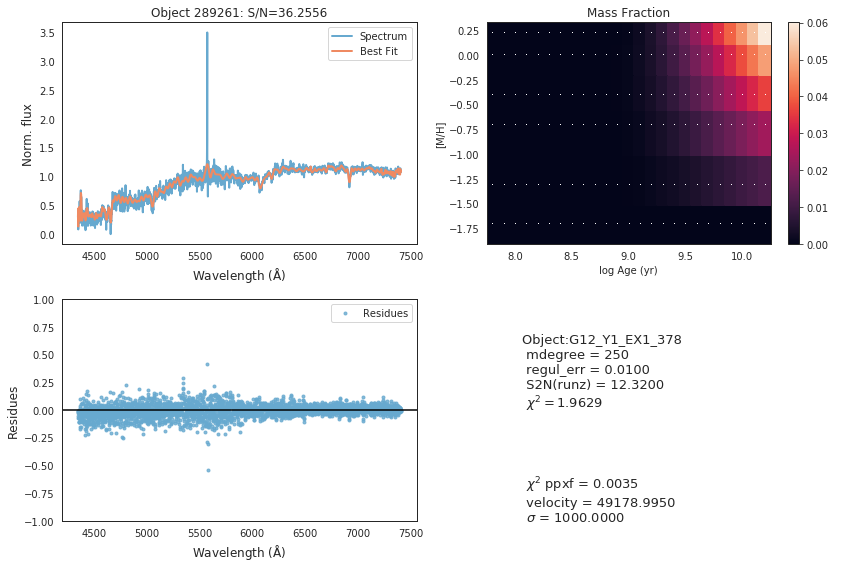

We have run 20 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     53065      1000     0.300     0.300
 comp. 1:     51929      1000
 comp. 2:     51135       146
chi2/DOF: 0.00349
method = capfit ; Jac calls: 15 ; Func calls: 3906 ; Status: 2
Gas Reddening E(B-V): 8.061
Nonzero Templates:  75  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      36.46       4.8   51929  1000
Comp: 2       Unknown          0       5.2   51135   146
Comp: 2       Unknown          0       2.2   51135   146
Comp: 2       Unknown      0.887       4.5   51135   146
---------------------------------------------------------
Weighted <logAge> [yr]: 9.88
Weighted <[M/H]>: -0.196
Weighted <logAge> [yr]: 9.88
Weighted <[M/H]>: -0.196
M/L_r: 3.0

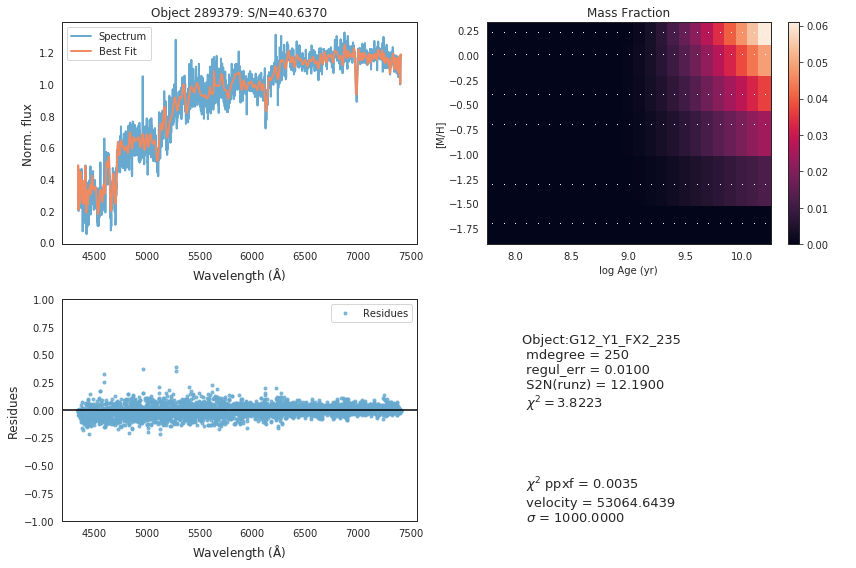

We have run 21 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     73195       789    -0.051     0.053
 comp. 1:     73388       608
 comp. 2:     72826       340
chi2/DOF: 0.007707
method = capfit ; Jac calls: 15 ; Func calls: 3905 ; Status: 2
Gas Reddening E(B-V): 1.251
Nonzero Templates:  120  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown       14.4       4.3   73388   608
Comp: 2       Unknown          0        15   72826   340
Comp: 2       Unknown      2.143        15   72826   340
Comp: 2       Unknown     0.9837       4.6   72826   340
---------------------------------------------------------
Weighted <logAge> [yr]: 9.75
Weighted <[M/H]>: -0.389
Weighted <logAge> [yr]: 9.75
Weighted <[M/H]>: -0.389
M/L_r: 1

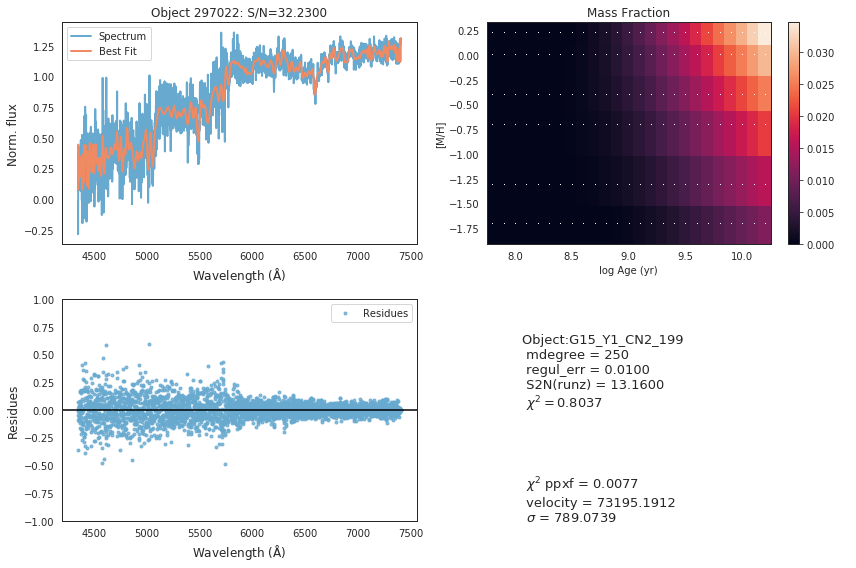

We have run 22 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OII]3729' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     46502      1000     0.300     0.300
 comp. 1:     46645       149
 comp. 2:     46410       443
chi2/DOF: 0.002534
method = capfit ; Jac calls: 14 ; Func calls: 3650 ; Status: 2
Gas Reddening E(B-V): 6.763
Nonzero Templates:  77  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown     0.2396       1.9   46645   149
Comp: 2       Unknown          0       1.1   46410   443
Comp: 2       Unknown      2.794       7.8   46410   443
Comp: 2       Unknown          0         4   46410   443
---------------------------------------------------------
Weighted <logAge> [yr]: 9.88
Weighted <[M/H]>: -0.196
Weighted <logAge> [yr]: 9.88
Weighted <[M/H]>: -0.196
M/L_r: 3

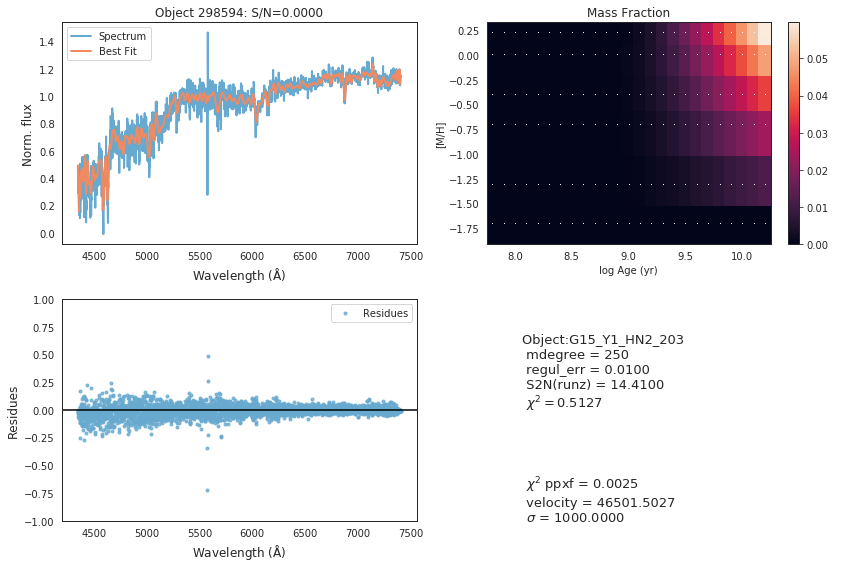

We have run 23 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     59878      1000     0.070     0.125
 comp. 1:     59277       571
 comp. 2:     59572       745
chi2/DOF: 0.01016
method = capfit ; Jac calls: 12 ; Func calls: 3125 ; Status: 2
Gas Reddening E(B-V): 2.969
Nonzero Templates:  99  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      14.79       5.2   59277   571
Comp: 2       Unknown          0        38   59572   745
Comp: 2       Unknown          0        38   59572   745
Comp: 2       Unknown      24.17       8.7   59572   745
---------------------------------------------------------
Weighted <logAge> [yr]: 9.82
Weighted <[M/H]>: -0.239
Weighted <logAge> [yr]: 9.82
Weighted <[M/H]>: -0.239
M/L_r: 2.5

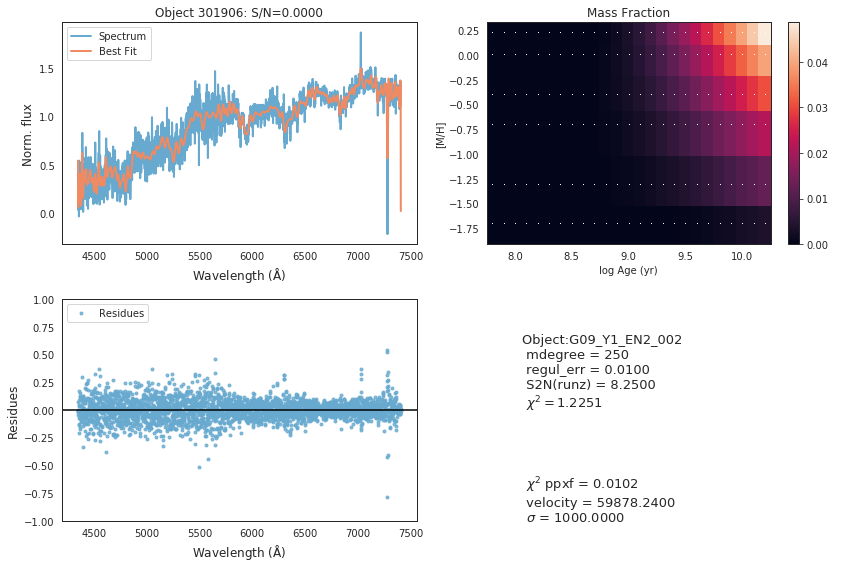

We have run 24 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     35243      1000     0.001     0.159
 comp. 1:     35193        35
 comp. 2:     34925       807
chi2/DOF: 0.001893
method = capfit ; Jac calls: 20 ; Func calls: 5206 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  145  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown     0.7521       3.4   35193    35
Comp: 2       Unknown          0         8   34925   807
Comp: 2       Unknown       3.09       6.3   34925   807
Comp: 2       Unknown       31.3       5.7   34925   807
---------------------------------------------------------
Weighted <logAge> [yr]: 9.72
Weighted <[M/H]>: -0.704
Weighted <logAge> [yr]: 9.72
Weighted <[M/H]>: -0.704
M/L_r

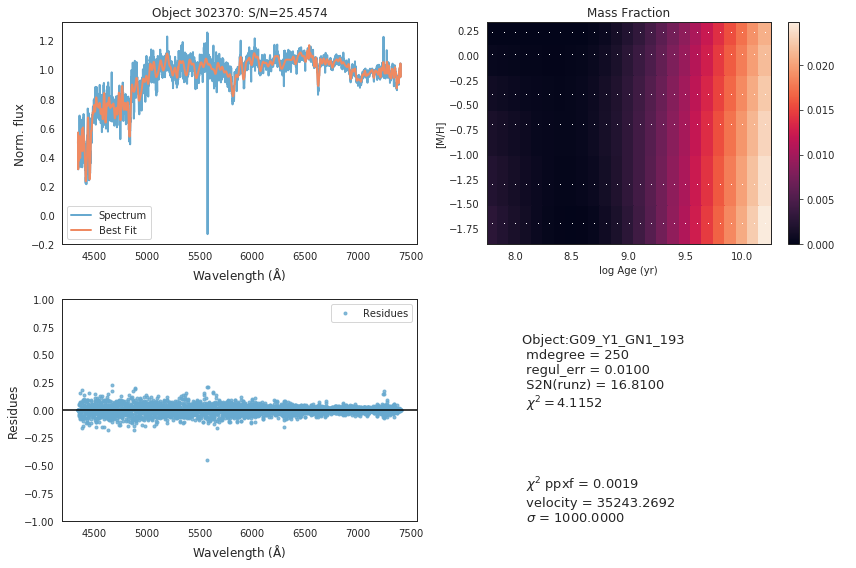

We have run 25 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OII]3729' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     46257       839     0.067     0.217
 comp. 1:     46300       248
 comp. 2:     46673       252
chi2/DOF: 0.005892
method = capfit ; Jac calls: 10 ; Func calls: 2602 ; Status: 2
Gas Reddening E(B-V): 4.459
Nonzero Templates:  90  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      1.132       2.4   46300   248
Comp: 2       Unknown          0         6   46673   252
Comp: 2       Unknown       5.63       8.6   46673   252
Comp: 2       Unknown     0.2848       3.4   46673   252
---------------------------------------------------------
Weighted <logAge> [yr]: 9.84
Weighted <[M/H]>: -0.202
Weighted <logAge> [yr]: 9.84
Weighted <[M/H]>: -0.202
M/L_r: 2

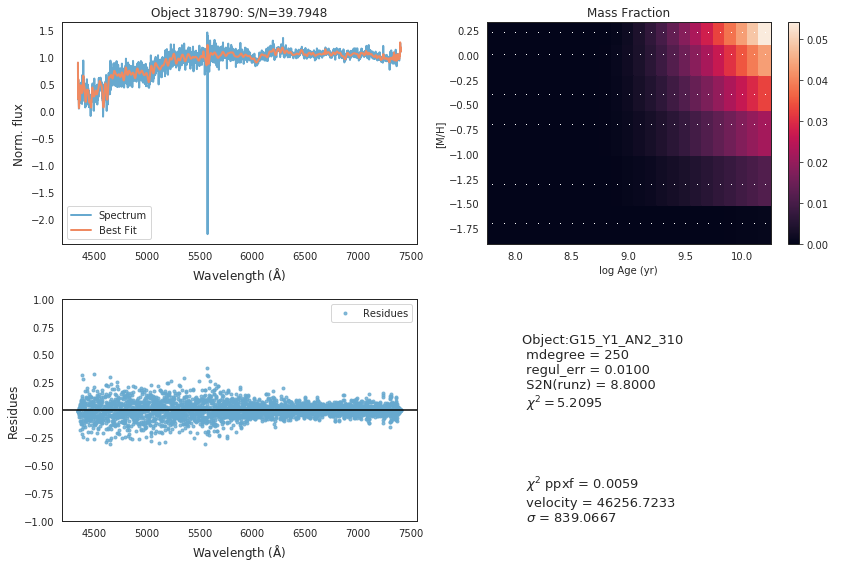

We have run 26 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     38404      1000     0.300     0.300
 comp. 1:     35770      1000
 comp. 2:     36542       375
chi2/DOF: 0.05519
method = capfit ; Jac calls: 21 ; Func calls: 5463 ; Status: 2
Gas Reddening E(B-V): 7.518
Nonzero Templates:  80  /  153
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      104.7         9   35770  1000
Comp: 2       Unknown      1.185       5.4   36542   375
Comp: 2       Unknown      3.848       4.5   36542   375
---------------------------------------------------------
Weighted <logAge> [yr]: 9.91
Weighted <[M/H]>: -0.247
Weighted <logAge> [yr]: 9.91
Weighted <[M/H]>: -0.247
M/L_r: 3.129
Current $\chi^2$: 0.0552
Elapsed time in PPXF: 45.27 [min]
Weight

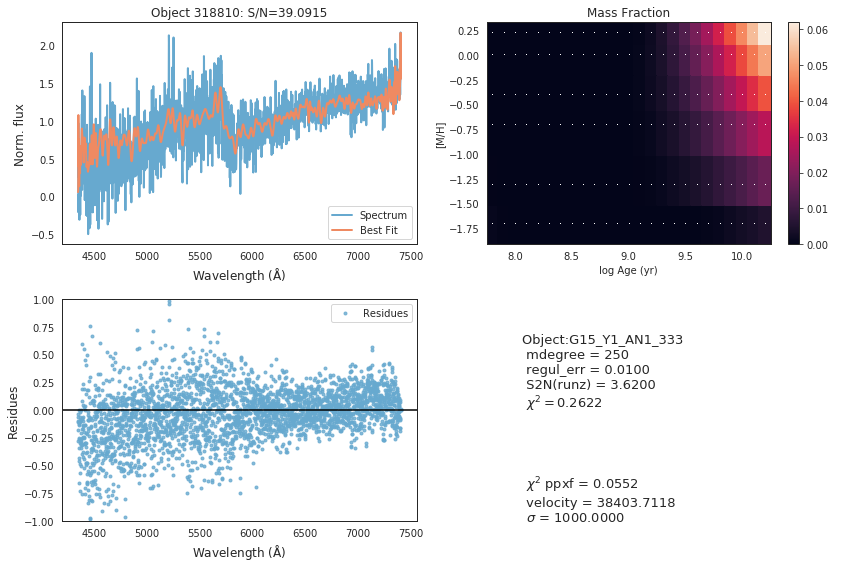

We have run 27 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     48019      1000     0.300     0.300
 comp. 1:     46894      1000
 comp. 2:     45059      1000
chi2/DOF: 0.01121
method = capfit ; Jac calls: 19 ; Func calls: 4949 ; Status: 2
Gas Reddening E(B-V): 10.000
Nonzero Templates:  73  /  153
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      43.92       5.3   46894  1000
Comp: 2       Unknown          0       9.2   45059  1000
Comp: 2       Unknown      57.28       7.3   45059  1000
---------------------------------------------------------
Weighted <logAge> [yr]: 9.91
Weighted <[M/H]>: -0.206
Weighted <logAge> [yr]: 9.91
Weighted <[M/H]>: -0.206
M/L_r: 3.301
Current $\chi^2$: 0.0112
Elapsed time in PPXF: 36.16 [min]
Weigh

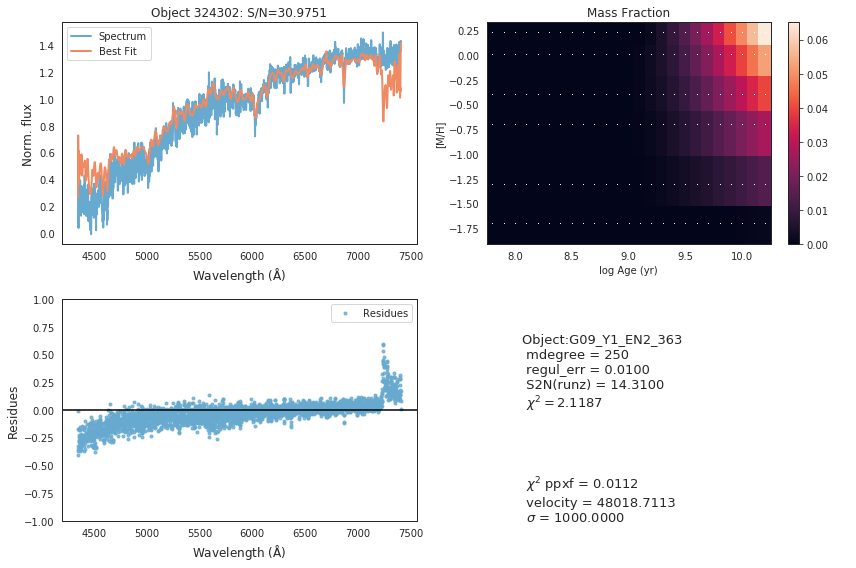

We have run 28 galaxies so far
Emission lines included in gas templates:
['Balmer' '[OIII]5007_d' '[OI]6300_d']


In [ ]:
all_start = time.clock()
for each_sed in range(len(seds_list_all)):
# for each_sed in range(1):
    
    # settings for the progress bar widget above: does not influence in ppxf -----------------------------------------
    bar.value += each_sed/4.                                          # signal to increment the progress bar
    if each_sed<len(seds_list_all): 
        bar.bar_style = ""                                            # blue when in progress
    else: 
        bar.bar_style = "success"                                     # green when it finishes 
        
    # ================================================================================================================
    # flux -----------------------------------------------------------------------------------------------------------
    sed_file  = os.path.join(seds_path, seds_list_all[each_sed])      # link between path and files
    sed_flux  = pf.getdata(sed_file)[0]                               # opening each spectra
    sed_err   = pf.getdata(sed_file)[1]                               # opening each spectra error
    
    # wavelength -----------------------------------------------------------------------------------------------------
    sed_header = pf.open(sed_file)[0].header
    sed_wl_ini = sed_header['WMIN'] 
    sed_wl_stp = sed_header['CD1_1']
    sed_wl     = np.arange(sed_flux.size)*(sed_wl_stp)+sed_wl_ini     # sed wavelength    
#     plot_sed(sed_wl, sed_flux, sed_err)
    
    # cleaning flux and wavelength trash -----------------------------------------------------------------------------
    idx_clean       = np.where((np.logical_not(np.isnan(sed_flux)))*(sed_err>0))    # indices where NAN is present
    flux_temp       = sed_flux[idx_clean]                                           # removing NAN values from spectra
    flux_temp_err   = sed_err[idx_clean]
    wavelength_temp = sed_wl[idx_clean]    
#     plot_sed(wavelength_temp, flux_temp, flux_temp_err)
    
    # limiting the spectrum regarding the wavelength range of the library --------------------------------------------
    wl_lib_idx = (wavelength_temp>wl_min) & (wavelength_temp<wl_max)       # MILES wavelength range
    flux       = flux_temp[wl_lib_idx]
    flux_err   = flux_temp_err[wl_lib_idx]
    wavelength = wavelength_temp[wl_lib_idx]    
#     plot_sed(wavelength, flux, flux_err)    
    
    # other important parameters -------------------------------------------------------------------------------------
    redshift  = sed_header['Z']
    cataid    = sed_header['CATAID']
    theo_gama = np.linspace(wl_min_miles, wl_max_miles, 4300)/1300.  # wl range same as miles and fwhm calc.all
  
    # ================================================================================================================
    # ppxf -----------------------------------------------------------------------------------------------------------
    vel_scale          = light_speed*np.log(wavelength[1]/wavelength[0])      # velocity scale - Eq.8 Capellari 2017
    
    ### setup templates ----------------------------------------------------------------------------------------------
    #### stellar pops ------------------------------------------------------------------------------------------------
    miles              = lib.miles(miles_lib, vel_scale, theo_gama)
    stellar_templates  = miles.templates.reshape(miles.templates.shape[0], -1)
    reg_dim            = miles.templates.shape[1:]
    dv                 = light_speed*(miles.log_lam_temp[0] - np.log(wavelength[0]))  # eq.(8) of Cappellari (2017)
    vel                = light_speed*np.log(1 + redshift)                             # eq.(8) of Cappellari (2017)
    start              = [vel, 180.]
    
    #### gas templates -----------------------------------------------------------------------------------------------
    wl_range_galaxy = np.array([np.min(wavelength), np.max(wavelength)])/(1 + redshift)
    
    gas_templates, gas_names, line_wave = util.emission_lines(miles.log_lam_temp, wl_range_galaxy, fwhm_gama, 
                                                              tie_balmer=tied_balmer, limit_doublets=limit_doublets)
    number_of_templates = stellar_templates.shape[1]
    number_of_forbidden = np.sum(["[" in a for a in gas_names])                      # forbidden lines contain "[*]"
    number_of_balmer    = len(gas_names) - number_of_forbidden
        
    component = (stellar_comp_w*number_of_templates)+(balmer_comp_w*number_of_balmer)+(forbid_comp_w
                                                                                       *number_of_forbidden)
        
    gas_component = np.array(component) > 0       # gas_component=True for gas templates
    start3        = [start, start, start]         # adopt the same starting value for the 3 components
    gas_reddening = 0 if tied_balmer else None    # If the Balmer lines are tied one should allow for gas reddening.
    
    
    #### all templates -----------------------------------------------------------------------------------------------
    all_templates = np.column_stack([stellar_templates, gas_templates])
    
    ### rebinning the spectrum so it is at the same size as the templates (or smaller) -------------------------------
    new_shape          = stellar_templates[:,0].shape
    rebinning_function = sci.interp1d(wavelength, flux)   # for the flux
    wavelength_rebin   = np.linspace(start=wavelength.min(), stop=wavelength.max(), num=int(new_shape[0]))
    flux_rebin         = rebinning_function(wavelength_rebin)
    
    ### rebinning the error ------------------------------------------------------------------------------------------
    rebin_func_error   = sci.interp1d(wavelength, flux_err)
    wl_rebin_error     = np.linspace(start=wavelength.min(), stop=wavelength.max(), num=int(new_shape[0]))
    flux_err_rebin     = rebin_func_error(wavelength_rebin)
    
    ### final galaxy spectrum and its error to be analysed -----------------------------------------------------------
    galaxy             = flux_rebin/np.median(flux_rebin)               # Normalize spectrum to avoid numerical issues
    noise              = flux_err_rebin/np.median(flux_err_rebin)       # idem
       
#     plot_sed(wavelength_rebin, galaxy, noise)
    
    # ================================================================================================================    
    ### SED FITTING WITH PPXF ----------------------------------------------------------------------------------------
    start_time = time.clock()
    sed_fit = ppxf(templates=all_templates, galaxy=galaxy, noise=noise, velscale=vel_scale, start=start3, plot=False, 
                   lam=wavelength_rebin, moments=moments, degree=degree, mdegree=mdegree, regul=1./regul_err, 
                   reg_dim=reg_dim, vsyst=dv, clean=False, component=component, gas_component=gas_component,
                   gas_reddening=gas_reddening)
    end_time = time.clock()
    
    ## output parameters -- most of them will become a dataframe at the end of the script  
    residues = (galaxy-sed_fit.bestfit)
    
    stellar_weights = sed_fit.weights[~gas_component]                         # Exclude weights of the gas templates
    stellar_weights = stellar_weights.reshape(reg_dim)/stellar_weights.sum()  # Normalized
    
    velocity = sed_fit.sol[0][0]
    sigma    = sed_fit.sol[0][1]
    
    mean_age.append(miles.mean_age_metal(stellar_weights)[0])
    mean_metal.append(miles.mean_age_metal(stellar_weights)[1])
    mass2light.append(miles.mass_to_light(stellar_weights, band="r"))
    ids.append(cataid)
    redshifts.append(redshift)
    s2n_runz.append(sed_header['SN'])
    ppxf_chi2.append(sed_fit.chi2)
       
    print(r"Current $\chi^2$: %.4f" % (sed_fit.chi2))
    print('Elapsed time in PPXF: %.2f [min]' % ((end_time-start_time)/60))
    
    # ================================================================================================================    
    ### Saving results from the SED fitting (csv and fits) -----------------------------------------------------------
    output = {}
    output['wavelength']  = wavelength_rebin
    output['flux']        = sed_fit.galaxy
    output['best_fit']    = sed_fit.bestfit
    output['gas_bestfit'] = sed_fit.gas_bestfit
    
    output_df = pd.DataFrame(output)
    basename  = str(cataid)+'_'+str(mdegree)+'_'+str(wl_min)
    output_df.to_csv(os.path.join('../../LargeFilesResults/SEDFitting/', 'fit_'+basename+'.csv'), index=False)
    
    #### HDU METADATA ------------------------------------------------------------------------------------------------
    metadata             = pf.Header()
    metadata['CATAID']   = cataid
    metadata['SPECID']   = sed_header['SPECID']
    metadata['Z']        = redshift
    metadata['FIT_CODE'] = 'pPXF'
    metadata['LIB']      = 'MILES'
    metadata['Isochr']   = 'PADOVA+00'
    metadata['Version']  = '11.0'
    metadata['COMMENT']  = 'MILES library covers the range of wavelength 3540-7409'
    metadata['WMIN']     = wl_min
    metadata['WMAX']     = wl_max
    metadata['mdegree']  = mdegree
    metadata['LogAGE']   = miles.mean_age_metal(stellar_weights)[0]
    metadata['MET_M2H']  = miles.mean_age_metal(stellar_weights)[1]
    metadata['M2L_r']    = miles.mass_to_light(stellar_weights, band="r")
    metadata['SIGMA']    = sigma
    metadata['VELOCITY'] = velocity
    metadata['DATE']     = dt.datetime.now().strftime("%d/%m/%Y")
    metadata['TIME']     = dt.datetime.now().strftime("%H:%M:%S")

    primary_hdu = pf.PrimaryHDU(header=metadata)
    
    #### HDU DATA ----------------------------------------------------------------------------------------------------
    column01 = pf.Column(name='wavelength', format='D', array=wavelength_rebin)
    column02 = pf.Column(name='flux', format='D', array=sed_fit.galaxy)
    column03 = pf.Column(name='best_fit', format='D', array=sed_fit.bestfit)
    column04 = pf.Column(name='residues', format='D', array=residues)
    column05 = pf.Column(name='templates_weights', format='D', array=sed_fit.weights)
    
    columns = pf.ColDefs([column01, column02, column03, column04, column05])
    output_hdu = pf.BinTableHDU.from_columns(columns)
    
    #### FULL HDU INTO FITS FILE -------------------------------------------------------------------------------------
    all_hdu = pf.HDUList([primary_hdu, output_hdu])
    all_hdu.writeto(os.path.join('../../LargeFilesResults/SEDFitting/', 'fit_'+basename+'.fits'))
    
    # ================================================================================================================
    ### Saving plots -------------------------------------------------------------------------------------------------
    plt.subplots(figsize=(12,8))
    
    #### plot01 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,1)
    plt.plot(wavelength_rebin, sed_fit.galaxy, '-', color=palette[-1], linewidth=lw, label="Spectrum")
    plt.plot(wavelength_rebin, sed_fit.bestfit, '-', color=palette[0], linewidth=lw, label="Best Fit")
    plt.title("Object %s: S/N=%.4f" % (cataid, s2n[each_sed]))
    plt.legend(loc='best')
    plt.xlabel("Wavelength ($\mathrm{\AA}$)", fontsize=12)
    plt.ylabel("Norm. flux", fontsize=12)
    
    #### plot02 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,2)
    miles.plot(stellar_weights)
    
    #### plot03 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,3)
    plt.plot(wavelength_rebin, residues, '.', color=palette[-1], linewidth=lw, label="Residues", alpha=transparency)
    plt.axhline(y=0, c='black')
    plt.legend(loc='best')
    plt.xlabel("Wavelength ($\mathrm{\AA}$)", fontsize=12)
    plt.ylabel("Residues", fontsize=12)
    plt.ylim([-1,1])
    
    #### plot04 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,4)
    plt.text(0.1, 0.5, "Object:{:s} \n mdegree = {:d} \n regul_err = {:.4f}\n S2N(runz) = {:.4f} \n $\chi^2 = ${:.4f}"
             .format(sed_header['SPECID'], mdegree, regul_err, sed_header['SN'], chi2_gama[idx_uvup_rp][each_sed]), 
             fontsize=13)
    plt.text(0.1, 0.0, " \n $\chi^2$ ppxf = {:.4f} \n velocity = {:.4f} \n $\sigma$ = {:.4f}"
             .format(sed_fit.chi2, velocity, sigma), fontsize=13)
    plt.axis('off') 
    
    plt.tight_layout()
    plt.savefig(os.path.join('../../LargeFilesResults/SEDFitting/', 'gal_'+basename+'.png'), dpi=100)
    plt.show()
    print ("We have run %d galaxies so far" % int(len(ids)-1))
    
all_end = time.clock()
print("------------------------------------------")
print('Elapsed time for all spectra: %.2f [min]' % ((all_end-all_start)/60))
print("------------------------------------------")

In [ ]:
### Saving outputs as dataframe ----------------------------------------------------------------------------------
ids        = np.array(ids)
redshifts  = np.array(redshifts)
mean_age   = np.array(mean_age)
mean_metal = np.array(mean_metal)
mass2light = np.array(mass2light)
s2n_runz   = np.array(s2n_runz)
ppxf_chi2  = np.array(ppxf_chi2)
outputs    = np.column_stack((ids, redshifts, mean_age, mean_metal, mass2light, s2n_runz, ppxf_chi2))
columns    = outputs[0,:]
outputs_dataframe = pd.DataFrame(outputs[1:,:])
outputs_dataframe.columns = columns
outputs_dataframe.to_csv('../../LargeFilesResults/SEDFitting/'+'ouputs_ppxf_'+str(mdegree)+'_'+str(wl_min)+'.csv', 
                         index=False)

In [ ]:
plt.subplots(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(s2n_runz, bins=bins, color=palette[0])
plt.yscale('log')
plt.subplot(1,2,2)
plt.hist(ppxf_chi2, bins=bins, color=palette[3])
plt.yscale('log')
plt.show()